# Limpieza inicial de las tablas

In [ ]:
import pandas as pd
import numpy as np

# ---------------------------
# FUNCIONES AUXILIARES
# ---------------------------
def limpiar_dataframe(df):
    """Estandariza nombres de columnas y reemplaza valores nulos o inválidos."""
    df.columns = [str(col).strip().lower().replace(" ", "_") for col in df.columns]
    df.replace(["s/d", "S/D", "-", "", " "], np.nan, inplace=True)
    return df

def convertir_a_numerico(df, columnas_excluidas=[]):
    for col in df.columns:
        if col not in columnas_excluidas:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

# ---------------------------
# CARGA DE DATOS
# ---------------------------

# 1. Focos de calor por jurisdicción y año
focos = pd.read_excel(r"datasets\Cantidad de focos de calor registrados por jurisdicción y año.xlsx")
focos = limpiar_dataframe(focos)
focos = convertir_a_numerico(focos, columnas_excluidas=["jurisdicción"])

# 2. Incendios por mes
incendios = pd.read_excel(r"datasets\Cantidad de incendios reportados por mes.xlsx")
incendios = limpiar_dataframe(incendios)
incendios = convertir_a_numerico(incendios, columnas_excluidas=["jurisdicción", "año"])

# 3. Estadísticas normales (múltiples hojas)
estadisticas = pd.read_excel(r"datasets\Estadísticas normales Datos abiertos 1991-2020- TODAS HOJAS.xlsx", sheet_name=None)
estadisticas_limpias = {}
for hoja, df in estadisticas.items():
    df = limpiar_dataframe(df)
    df = convertir_a_numerico(df)
    estadisticas_limpias[hoja] = df

# 4. Densidad de población por cuenca
poblacion = pd.read_excel(r"datasets\Densidad de población por cuenca.xlsx")
poblacion = limpiar_dataframe(poblacion)
poblacion = convertir_a_numerico(poblacion, columnas_excluidas=["cuenca"])

# 5. Superficie afectada
superficie_abs = pd.read_excel(r"datasets\Superficie afectada por incendios reportados, por jurisdicción.xlsx", sheet_name="rii_c_hectareas_incendios_prov_")
superficie_pct = pd.read_excel(r"datasets\Superficie afectada por incendios reportados, por jurisdicción.xlsx", sheet_name="Porcentaje de superficie afecta")

superficie_abs = limpiar_dataframe(superficie_abs)
superficie_abs = convertir_a_numerico(superficie_abs, columnas_excluidas=["jurisdicción"])

superficie_pct = limpiar_dataframe(superficie_pct)
superficie_pct["%_suma_de_hectareas"] = pd.to_numeric(superficie_pct["%_suma_de_hectareas"], errors='coerce')

# 6. Supertabla
supertabla = pd.read_excel(r"datasets\Supertabla.xlsx", sheet_name=None)
df1 = limpiar_dataframe(supertabla['hoja1'])
df2 = limpiar_dataframe(supertabla['hoja2'])

df1 = convertir_a_numerico(df1, columnas_excluidas=["jurisdicción"])
df2 = convertir_a_numerico(df2, columnas_excluidas=["jurisdicción", "combustible"])

# ---------------------------
# REVISIÓN POST-LIMPIEZA
# ---------------------------
print("✔ Limpieza completada.")
print("Dimensiones focos:", focos.shape)
print("Dimensiones incendios:", incendios.shape)
print("Dimensiones población:", poblacion.shape)
print("Dimensiones superficie afectada:", superficie_abs.shape)
print("Dimensiones supertabla_1:", df1.shape)
print("Dimensiones supertabla_2:", df2.shape)


# Analisis exploratorio de los Datos

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")  # estilo limpio
plt.rcParams["figure.figsize"] = (10, 6)

### Distribucion de focos de calor por jurisdiccion

C:\Users\fede4\AppData\Local\Temp\ipykernel_15548\3721574386.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=focos_ultimo, x=ultimo_anio, y="jurisdicción", palette="Reds_r")


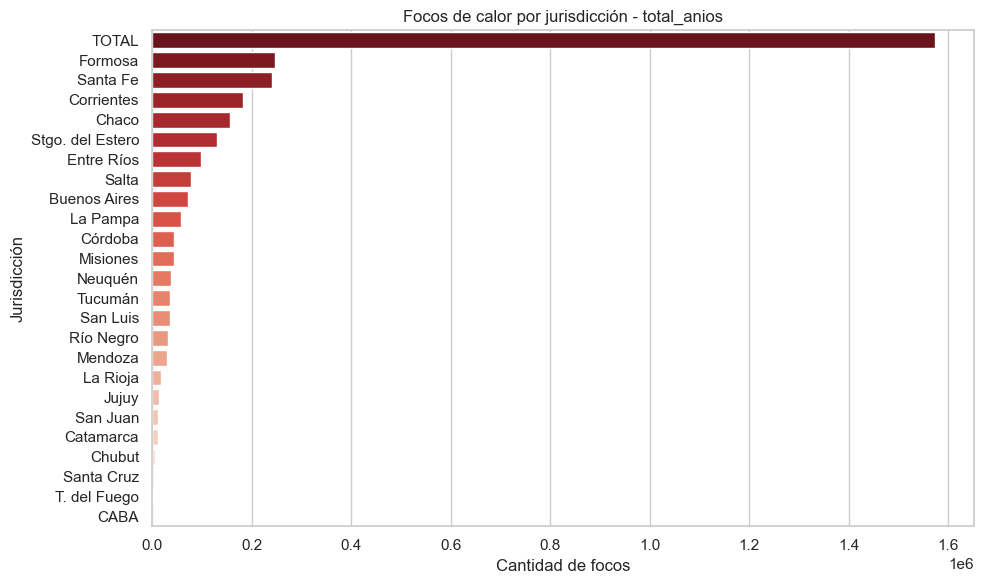

In [15]:
# Suponiendo que la última columna es el año más reciente
ultimo_anio = focos.columns[-1]
focos_ultimo = focos[["jurisdicción", ultimo_anio]].sort_values(by=ultimo_anio, ascending=False)

plt.figure()
sns.barplot(data=focos_ultimo, x=ultimo_anio, y="jurisdicción", palette="Reds_r")
plt.title(f"Focos de calor por jurisdicción - {ultimo_anio}")
plt.xlabel("Cantidad de focos")
plt.ylabel("Jurisdicción")
plt.tight_layout()
plt.show()
